In [1]:
import pandas as pd
import numpy as np
from joblib import dump, load
import time
import datetime
import operator

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import callbacks

from matplotlib import pyplot as plt

In [2]:
%load_ext tensorboard

### Some useful functions

In [3]:
def get_confusion_matrix(true_pos, false_pos, true_neg, false_neg):
    conf_matrix = np.array([
                            [true_pos, false_pos],
                            [false_neg, true_neg]
                           ])
    
    return pd.DataFrame(conf_matrix, columns=['1', '0'], index=['1', '0'])

In [4]:
def learning_plot(model, metric):
    
    fig = plt.figure()
    
    fig = plt.plot(model.history[metric], color='black')
    fig = plt.plot(model.history['val_'+metric], color='blue')

    plt.title('Changes in {} over training run'.format(metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    
    plt.legend(['train', 'val'], loc='upper right')
    
    return fig

In [5]:
def learning_recall(model, positives_flag=True):
    
    if positives_flag:
        recall = [tp / (tp+fn) for tp, fn in zip(model.history['true_positives'], model.history['false_negatives'])]
        val_recall = [tp / (tp+fn) for tp, fn in zip(model.history['val_true_positives'], model.history['val_false_negatives'])]
        recall_type = 'positive'
    else:
        recall = [tn / (tn+fp) for tn, fp in zip(model.history['true_negatives'], model.history['false_positives'])]
        val_recall = [tn / (tn+fp) for tn, fp in zip(model.history['val_true_negatives'], model.history['val_false_positives'])]
        recall_type = 'negative'
        
    fig = plt.figure()
    
    fig = plt.plot(recall, color='black')
    fig = plt.plot(val_recall, color='blue')
    
    plt.title('Changes in {} recall rate over training run.'.format(recall_type))
    plt.xlabel('Epoch')
    plt.ylabel('{} recall rate'.format(recall_type))
    
    return fig

In [6]:
def random_search_models(num_models, input_dims, compile_metrics, seed):
    
    np.random.seed(seed)
    
    all_models = []
    
    for m in range(num_models): 
        
        num_hidden_layers = np.random.randint(1, 11)
        all_models.append(build_model(num_hidden_layers, input_dims, compile_metrics))
    
    return all_models

def build_layers(num_layers, input_dims):

    layers = []
    
    for i in range(num_layers):
        
        num_units = np.random.randint(2, 27)
        reg_val = 10**(-4*np.random.rand())
        if i==0:
            layers.append(Dense(
                                units = num_units,
                                input_dim = input_dims,
                                activation = 'relu',
                                kernel_regularizer = l2(l2=reg_val)
                               ))
        else:
            layers.append(Dense(
                                units = num_units,
                                activation = 'relu',
                                kernel_regularizer = l2(l2=reg_val)
                               ))
    reg_val = 10**(-4*np.random.rand())
    layers.append(Dense(
                        units = 1,
                        activation = 'sigmoid',
                        kernel_regularizer = l2(l2=reg_val)
                       ))
    return layers

def build_model(num_hidden_layers, input_dims, compile_metrics):

    model = Sequential()
    
    layers = build_layers(num_hidden_layers, input_dims)
    for l in layers:
        model.add(l)
    
    learning_rate = 10**(-4*np.random.rand())
    model.compile(optimizer = Adam(learning_rate), loss='binary_crossentropy', metrics=[compile_metrics])
    
    return model

In [7]:
def get_best_models(model_list, metric, descending, num_models):
    
    m_tuples = []
    for model, history in model_list:
        m_tuples.append((model, history, history.history[metric][-1]))
        
    m_tuples.sort(key=operator.itemgetter(2), reverse=descending)
    
    if num_models:
        return m_tuples[:num_models]
    else:
        return m_tuples

### Load and prepare data

In [8]:
df = pd.read_csv('jazz.csv', sep='|')

In [9]:
# Define features to analyze
features = [
            'danceability',
            'energy',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'num_samples',
            'end_of_fade_in',
            'loudness',
            'tempo',
            'key',
            'mode',
            'bars_num',
            'bars_duration_var',
            'beats_duration_var',
            'sections_num',
            'sections_duration_mean',
            'sections_duration_var',
            'loudness_var',
            'tempo_var',
            'key_var',
            'mode_var',
            'segments_duration_var',
            'segments_duration_mean',
            'pitches_mean',
            'pitches_var',
            'timbre_mean',
            'timbre_var',
            'tatums_duration_var'
           ]

df = df[features+['label']]

# Shuffle data to ungroup class rows
df = df.sample(frac=1, random_state=12).reset_index(drop=True)

In [10]:
df[df['label']==1].shape

(1560, 31)

Split dataset into training, validation, and test. 60/20/20 gives ~936 positive training samples, and ~312 each of positive validation and test samples. Quite small, but hopefully big enough to be meaningful.

In [11]:
X = df[features].copy()
Y = df['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    Y, 
                                                    stratify = Y,
                                                    test_size = 0.2,
                                                    random_state = 42
                                                   )

# Start building model

In [12]:
# First fit how to scale data for the model
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

scale_model = pipeline.fit(X_train)
X_train = scale_model.transform(X_train)
X_test = scale_model.transform(X_test)

# Save for later use
dump(scale_model, 'scaler.joblib') 

['scaler.joblib']

In [13]:
logdir = 'logs/scalars/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)

metrics = [
           tfk.metrics.Precision(),
           tfk.metrics.TruePositives(),
           tfk.metrics.TrueNegatives(),
           tfk.metrics.FalsePositives(),
           tfk.metrics.FalseNegatives(),
           tfk.metrics.AUC(curve='PR')
          ]

models = random_search_models(num_models=25, input_dims=len(features), compile_metrics=metrics, seed=42)

model_list = []

for i, model in enumerate(models):

    training_history = model.fit(
                                 X_train,
                                 y_train,
                                 batch_size = 128,
                                 verbose = 0,
                                 epochs = 500,
                                 validation_split = 0.2,
                                 callbacks=[callbacks.TensorBoard(log_dir=logdir+'-'+str(i))],
                                )
    model_list.append((model, training_history))
    
    print('Average validation loss for model ', str(i+1), ': ', np.average(training_history.history['val_loss']))

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Average validation loss for model  1 :  1.2508745682239533
Average validation loss for model  2 :  0.7753959165811539
Average validation loss for model  3 :  0.7926709327697754
Average validation loss for model  4 :  0.7098618816137314
Average validation loss for model  5 :  0.6904952417612076
Average validation loss for model  6 :  0.7491241655349732
Average validation loss for model  7 :  1.1150947971343994
Average validation loss for model  8 :  0.5481753768324852
Average validation loss for model  9 :  0.695370208978653
Average validation loss for model  10 :  0.687155349612236
Average validation loss for model  11 :  0.5356590348482132
Average validation loss for model  12 :  0.7003069986104965
Average validation loss for model  13 :  0.9633011518716812
Average validation loss for model  14 :  0.5422413829565048
Average validation loss for model  15 :  0.817962370634079
Average validation loss for model  16 : 

In [14]:
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 444), started 4 days, 7:14:27 ago. (Use '!kill 444' to kill it.)

In [15]:
# Get five best models to evaluate on Tensorboard
model_list_sorted = get_best_models(model_list, 'val_auc', descending=True, num_models=5)

In [16]:
best_model = model_list_sorted[0][0]
best_history = model_list_sorted[0][1]

In [17]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 21)                651       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                264       
_________________________________________________________________
dense_2 (Dense)              (None, 22)                286       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                460       
_________________________________________________________________
dense_4 (Dense)              (None, 12)                252       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 65        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 2

# Evaluate model on validation set

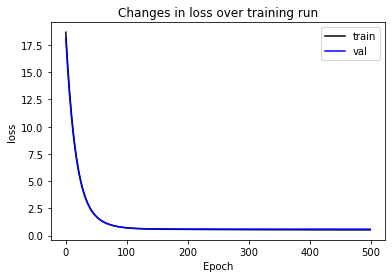

In [18]:
learning_plot(best_history, 'loss')

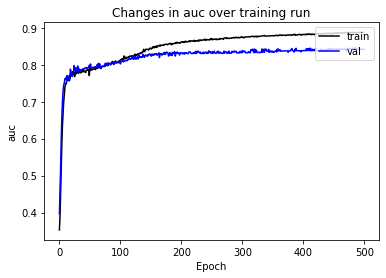

In [19]:
learning_plot(best_history, 'auc')

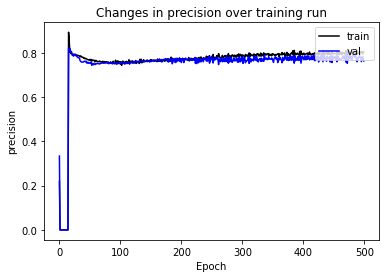

In [20]:
learning_plot(best_history, 'precision')

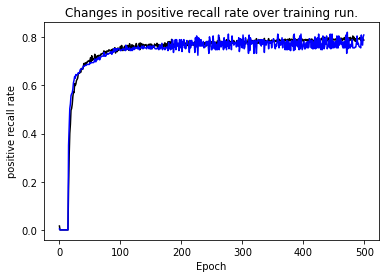

In [21]:
learning_recall(best_history, True)

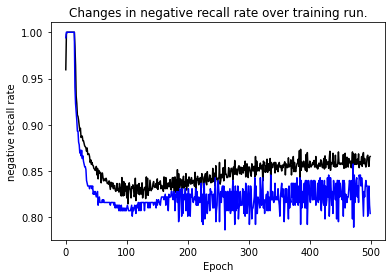

In [22]:
learning_recall(best_history, False)

In [23]:
loss = best_history.history['loss'][-1]
val_loss = best_history.history['val_loss'][-1]
print('Loss for training set is {}, while loss for validation set is {}. This gives a difference of {}'\
      .format(
              round(loss,4),
              round(val_loss,4), 
              round(val_loss-loss, 4))
             )

Loss for training set is 0.5282, while loss for validation set is 0.5944. This gives a difference of 0.0662


In [24]:
auc = best_history.history['auc'][-1]
val_auc = best_history.history['val_auc'][-1]
print('AUC for training set is {}, while AUC for validation set is {}. This gives a difference of {}'\
      .format(round(auc, 2), round(val_auc, 2), round(auc-val_auc,2)))

AUC for training set is 0.89, while AUC for validation set is 0.84. This gives a difference of 0.05


In [25]:
true_positives_val = best_history.history['val_true_positives'][-1]
false_positives_val = best_history.history['val_false_positives'][-1]
true_negatives_val = best_history.history['val_true_negatives'][-1]
false_negatives_val = best_history.history['val_false_negatives'][-1]

val_conf_matrix = get_confusion_matrix(
                                       true_positives_val,
                                       false_positives_val,
                                       true_negatives_val,
                                       false_negatives_val
                                      )

print('Confusion_matrix:\n{}'.format(val_conf_matrix))

Confusion_matrix:
       1      0
1  212.0   66.0
0   50.0  271.0


In [26]:
print('True recall rate is {}'\
      .format(round(val_conf_matrix.loc['1', '1']/(val_conf_matrix.loc['1', '1']+val_conf_matrix.loc['0', '1']),2)))
print('Precision is {}'.format(best_history.history['val_precision'][-1]))

True recall rate is 0.81
Precision is 0.7625899314880371


Looks very promising on validation set! Let's check test set

In [27]:
loss_test, precision_test, true_positives_test, true_negatives_test, false_positives_test, false_negatives_test, auc_test = best_model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 949us/step - loss: 0.5984 - precision: 0.7477 - true_positives: 246.0000 - true_negatives: 354.0000 - false_positives: 83.0000 - false_negatives: 66.0000 - auc: 0.8285


In [28]:
print('AUC for test set is {}.'.format(round(auc_test,2)))

AUC for test set is 0.83.


In [29]:
confusion_matrix = get_confusion_matrix(
                                        true_positives_test,
                                        false_positives_test,
                                        true_negatives_test,
                                        false_negatives_test
                                       )

In [30]:
print(confusion_matrix)

       1      0
1  246.0   83.0
0   66.0  354.0


In [31]:
print(
      'True recall rate is {}'\
      .format(round(
                    confusion_matrix.loc['1', '1']/
                    (confusion_matrix.loc['1', '1']+confusion_matrix.loc['0', '1']),
                    2
                   )
             )
     )
print('Precision is {}'.format(round(precision_test,2)))

True recall rate is 0.79
Precision is 0.75


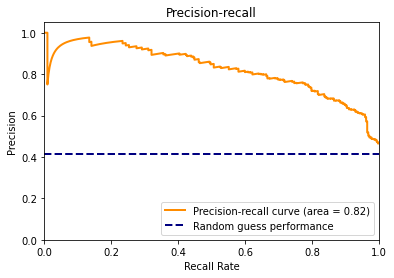

In [83]:
from sklearn import metrics
from sklearn.utils.class_weight import compute_sample_weight

# sample_weights = compute_sample_weight(class_weight='balanced', y=y_test)
random_pr = y_test.value_counts().iloc[1] / len(y_test)

predictions = best_model.predict(X_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, predictions)
pr_auc = metrics.auc(recall, precision)

plt.figure()
lw = 2
plt.plot(
         recall, 
         precision, 
         color = 'darkorange',
         lw = lw, 
         label = 'Precision-recall curve (area = {})'.format(round(pr_auc,2))
        )
plt.plot([0, 1], [random_pr, random_pr], color='navy', lw=lw, linestyle='--', label='Random guess performance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall Rate')
plt.ylabel('Precision')
plt.title('Precision-recall')
plt.legend(loc = 'lower right')

# Save model

In [32]:
best_model.save('jazz_model')